In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import pickle
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
ResNet50_MODEL=tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights="imagenet")

In [4]:
len(ResNet50_MODEL.layers)

175

In [5]:
ResNet50_MODEL.layers[15].name

'conv2_block1_0_bn'

In [6]:
for layer in ResNet50_MODEL.layers:
    layer.trainable=True

In [7]:
ResNet50_MODEL.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
batch_size = 64
l1_factor = 0.0001
l2_factor = 0.001
dropout = 0.5
learning_rate = 0.0001
target_size_image_shape = (224, 224)

In [9]:
model=tf.keras.models.Sequential([
                                  ResNet50_MODEL,
                                  tf.keras.layers.GlobalAveragePooling2D(),
                                  tf.keras.layers.Dropout(dropout, name='Dropout_Regularization1'),
                                  tf.keras.layers.Dense(10061, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
Dropout_Regularization1 (Dro (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10061)             20614989  
Total params: 44,202,701
Trainable params: 44,149,581
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
train_data_dir = '../datasets/group3_set_224/set_224/train/'
valid_data_dir = '../datasets/group3_set_224/set_224/valid/'

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [12]:
#flow training images
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 129266 images belonging to 10061 classes.


In [13]:
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 50305 images belonging to 10061 classes.


### Save Labels in  Json file

In [14]:
indices_to_class_labels_dict = {value : key for key, value in train_generator.class_indices.items()}
print(len(indices_to_class_labels_dict))
print(indices_to_class_labels_dict)
with open("group3_indices_to_class_labels_dict.json", "wb") as pickle_file:
    pickle.dump(indices_to_class_labels_dict, pickle_file)

10061
{0: '0', 1: '100018', 2: '100049', 3: '10006', 4: '100094', 5: '10010', 6: '100127', 7: '100146', 8: '100155', 9: '10018', 10: '100239', 11: '10028', 12: '100289', 13: '100300', 14: '100302', 15: '100303', 16: '100316', 17: '100341', 18: '100354', 19: '100392', 20: '100399', 21: '100409', 22: '100413', 23: '100414', 24: '100415', 25: '100431', 26: '100443', 27: '100461', 28: '100464', 29: '100466', 30: '100475', 31: '100492', 32: '100495', 33: '10051', 34: '100511', 35: '100517', 36: '100555', 37: '100566', 38: '100589', 39: '10059', 40: '100595', 41: '100612', 42: '100615', 43: '100616', 44: '100661', 45: '100689', 46: '100706', 47: '10072', 48: '100731', 49: '10082', 50: '100841', 51: '100846', 52: '100863', 53: '100869', 54: '100878', 55: '10089', 56: '10091', 57: '100927', 58: '100930', 59: '100956', 60: '10096', 61: '100971', 62: '100995', 63: '101034', 64: '101068', 65: '101077', 66: '101083', 67: '101084', 68: '101110', 69: '101152', 70: '101175', 71: '101214', 72: '101219

### Callbacks and Fitting Modeling

In [15]:
outputFolder = 'checkpoints_group3'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
checkpoint_filepath=outputFolder+"/model-{epoch:02d}-{val_acc:.2f}.hdf5"

In [16]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_acc', verbose=1, mode='max',
    save_best_only=True, save_weights_only=True,
    save_frequency='epoch')

In [17]:
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // batch_size,
    callbacks=[checkpoint_callback],
    epochs = 100,
    workers = 4,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
2019/2019 [==============================] - ETA: 0s - loss: 9.0495 - acc: 5.1851e-04
Epoch 00001: val_acc improved from -inf to 0.00622, saving model to checkpoints_group3/model-01-0.01.hdf5
2019/2019 [==============================] - 661s 328ms/step - loss: 9.0495 - acc: 5.1851e-04 - val_loss: 8.1799 - val_acc: 0.0062
Epoch 2/100
2019/2019 [==============================] - ETA: 0s - loss: 7.1373 - acc: 0.0431
Epoch 00002: val_acc improved from 0.00622 to 0.16658, saving model to checkpoints_group3/model-02-0.17.hdf5
2019/2019 [==============================] - 666s 330ms/step - loss: 7.1373 - acc: 0.0431 - val_loss: 5.7051 - val_acc: 0.1666
Epoch 3/100
2019/2019 [==============================] - ETA: 0s - loss: 4.9964 - acc: 0.2025
Epoch 00003: val_acc improved from 0.16658 to 0.25503, saving model to checkpoints_group3/model-03-0.26.hdf5
2019/2019 [==============================] - 666s 330ms/

2019/2019 [==============================] - ETA: 0s - loss: 0.2913 - acc: 0.9206
Epoch 00027: val_acc did not improve from 0.48859
2019/2019 [==============================] - 664s 329ms/step - loss: 0.2913 - acc: 0.9206 - val_loss: 5.4032 - val_acc: 0.4639
Epoch 28/100
2019/2019 [==============================] - ETA: 0s - loss: 0.2721 - acc: 0.9264
Epoch 00028: val_acc did not improve from 0.48859
2019/2019 [==============================] - 664s 329ms/step - loss: 0.2721 - acc: 0.9264 - val_loss: 5.8051 - val_acc: 0.4534
Epoch 29/100
2019/2019 [==============================] - ETA: 0s - loss: 0.2571 - acc: 0.9305
Epoch 00029: val_acc did not improve from 0.48859
2019/2019 [==============================] - 663s 328ms/step - loss: 0.2571 - acc: 0.9305 - val_loss: 5.3976 - val_acc: 0.4598
Epoch 30/100
2019/2019 [==============================] - ETA: 0s - loss: 0.2429 - acc: 0.9342
Epoch 00030: val_acc did not improve from 0.48859
2019/2019 [==============================] - 663s 32

Epoch 57/100
2019/2019 [==============================] - ETA: 0s - loss: 0.0975 - acc: 0.9727
Epoch 00057: val_acc did not improve from 0.49882
2019/2019 [==============================] - 663s 329ms/step - loss: 0.0975 - acc: 0.9727 - val_loss: 5.6845 - val_acc: 0.4924
Epoch 58/100
2019/2019 [==============================] - ETA: 0s - loss: 0.0990 - acc: 0.9721
Epoch 00058: val_acc did not improve from 0.49882
2019/2019 [==============================] - 664s 329ms/step - loss: 0.0990 - acc: 0.9721 - val_loss: 6.0687 - val_acc: 0.4820
Epoch 59/100
2019/2019 [==============================] - ETA: 0s - loss: 0.0943 - acc: 0.9740
Epoch 00059: val_acc did not improve from 0.49882
2019/2019 [==============================] - 664s 329ms/step - loss: 0.0943 - acc: 0.9740 - val_loss: 5.9846 - val_acc: 0.4844
Epoch 60/100
2019/2019 [==============================] - ETA: 0s - loss: 0.0919 - acc: 0.9743
Epoch 00060: val_acc did not improve from 0.49882
2019/2019 [============================

Epoch 87/100
2019/2019 [==============================] - ETA: 0s - loss: 0.0589 - acc: 0.9832
Epoch 00087: val_acc did not improve from 0.51090
2019/2019 [==============================] - 662s 328ms/step - loss: 0.0589 - acc: 0.9832 - val_loss: 6.0092 - val_acc: 0.4991
Epoch 88/100
2019/2019 [==============================] - ETA: 0s - loss: 0.0567 - acc: 0.9835
Epoch 00088: val_acc did not improve from 0.51090
2019/2019 [==============================] - 663s 328ms/step - loss: 0.0567 - acc: 0.9835 - val_loss: 6.7301 - val_acc: 0.4904
Epoch 89/100
2019/2019 [==============================] - ETA: 0s - loss: 0.0570 - acc: 0.9834
Epoch 00089: val_acc did not improve from 0.51090
2019/2019 [==============================] - 663s 328ms/step - loss: 0.0570 - acc: 0.9834 - val_loss: 6.8150 - val_acc: 0.4798
Epoch 90/100
2019/2019 [==============================] - ETA: 0s - loss: 0.0563 - acc: 0.9840
Epoch 00090: val_acc did not improve from 0.51090
2019/2019 [============================

<Figure size 432x288 with 0 Axes>

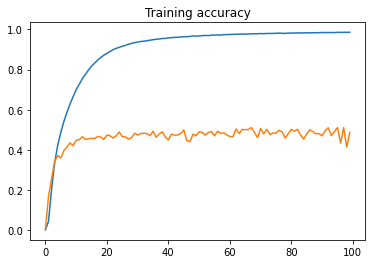

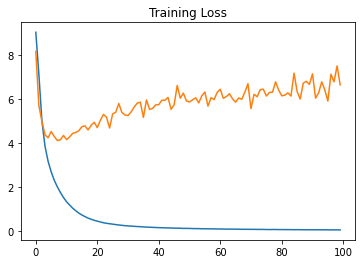

<Figure size 432x288 with 0 Axes>

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training Loss')
plt.figure()

In [19]:
gsedrfgdffg

NameError: name 'gsedrfgdffg' is not defined